In [80]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
#now = datetime.datetime.now()

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
macro = pd.read_csv('./data/macro.csv')
id_test = test.id
train.sample(3)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
25644,25647,2014-12-02,39,22.0,2.0,12.0,5.0,1974.0,2.0,6.0,...,24,4,0,5,19,1,4,49,5,7200000
18934,18937,2014-05-27,41,27.0,4.0,5.0,2.0,1966.0,2.0,5.0,...,3,3,0,7,16,0,9,49,10,6500000
28683,28686,2015-03-28,38,NaN,5.0,17.0,1.0,NaN,1.0,0.0,...,1,1,0,2,12,0,0,9,0,5437752


In [81]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)    

In [3]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [4]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 reg_lambda,
                 alpha):
#add l2
    params['min_child_weight'] = int(min_child_weight)
    params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['reg_lambda']=max(reg_lambda,0)

    cv_result = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(10)])

    return -cv_result['test-rmse-mean'].values[-1]


In [13]:
    from bayes_opt import BayesianOptimization
    num_rounds = 3000
    random_state = 2016
    num_iter = 50
    init_points = 10
    params = {
        'eta': 0.05,
        'silent': 1,
        'eval_metric': 'rmse',
        'verbose_eval': True,
        'seed': random_state
        
    }
    
    xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                                'colsample_bytree': (0.1, 1),
                                                'max_depth': (3, 15),
                                                'subsample': (0.5, 1),
                                                'gamma': (0, 10),
                                                'alpha': (0, 10),
                                                'reg_lambda':(0.5,10)
})

In [14]:
xgbBO.explore({'max_depth':[5],'subsample': [0.7],'colsample_bytree':[0.7],'gamma':[0],'alpha':[0],'reg_lambda':[1],'min_child_weight':[1] }) 
xgbBO.maximize(init_points=init_points, n_iter=num_iter,kappa=4)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   reg_lambda |   subsample | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[249]	train-rmse:1.95631e+06+16234.8	test-rmse:2.65008e+06+120947

    1 | 02m01s | -2650081.75000 |    0.0000 |             0.7000 |    0.0000 |      5.0000 |             1.0000 |       1.0000 |      0.7000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[255]	train-rmse:1.72683e+06+48935.1	test-rmse:2.62698e+06+117652

    2 | 03m21s | -2626977.25000 |    0.9249 |             0.4849 |    9.8657 |      8.4203

/home/robert/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1558686.828125]), 'nit': 4, 'warnflag': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49}
  " state: %s" % convergence_dict)


   25 | 04m23s | -2644501.05000 |    2.1235 |             0.1000 |    7.2078 |      5.5023 |             1.7447 |       4.8661 |      1.0000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[307]	train-rmse:1.82717e+06+22234.6	test-rmse:2.6299e+06+117139

   26 | 03m11s | -2629897.40000 |    0.3641 |             1.0000 |   10.0000 |      6.5201 |             3.5827 |       4.2824 |      0.5000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[292]	train-rmse:1.73015e+06+28643.6	test-rmse:2.62851e+06+128372

   27 | 03m31s | -2628506.85000 |    1.9333 |             0.1000 |    3.5104 |      7.3242 |             4.5358 |       5.2069 |      0.5000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train 

/home/robert/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2138995.9375]), 'nit': 4, 'warnflag': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47}
  " state: %s" % convergence_dict)


   33 | 02m38s | -2640348.80000 |    1.4925 |             1.0000 |    8.2810 |      5.7613 |             3.1145 |       4.8195 |      0.5000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[138]	train-rmse:285730+7834.37	test-rmse:2.76666e+06+79732.4

   34 | 04m13s | -2766659.25000 |    0.0000 |             1.0000 |   10.0000 |     15.0000 |             1.0000 |       0.5000 |      1.0000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[394]	train-rmse:1.71406e+06+26290.1	test-rmse:2.65348e+06+128310

   35 | 03m52s | -2653480.60000 |    3.8973 |             1.0000 |    8.4066 |      6.7495 |             3.1822 |       5.5676 |      1.0000 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train unt

In [17]:
xgbBO.res['max']

{'max_params': {'alpha': 1.9678523310361673,
  'colsample_bytree': 0.86244069127570411,
  'gamma': 7.8990994340520926,
  'max_depth': 5.742876719629507,
  'min_child_weight': 2.7926454538823444,
  'reg_lambda': 4.9292683890361317,
  'subsample': 0.61554597137499256},
 'max_val': -2624124.1499999999}

In [4]:


xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)



[0]	train-rmse:8.20593e+06	test-rmse:8.20865e+06
[50]	train-rmse:2.52775e+06	test-rmse:2.89073e+06
[100]	train-rmse:2.19272e+06	test-rmse:2.70565e+06
[150]	train-rmse:2.07303e+06	test-rmse:2.6703e+06
[200]	train-rmse:1.98557e+06	test-rmse:2.64838e+06
[250]	train-rmse:1.91812e+06	test-rmse:2.63979e+06
[300]	train-rmse:1.85714e+06	test-rmse:2.63207e+06
[350]	train-rmse:1.8054e+06	test-rmse:2.62911e+06
[400]	train-rmse:1.75614e+06	test-rmse:2.62691e+06


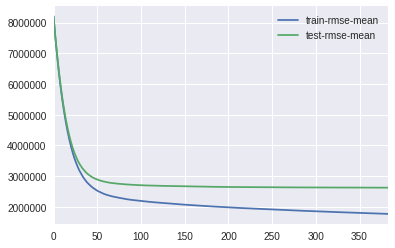

In [5]:


cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()



In [6]:


num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)



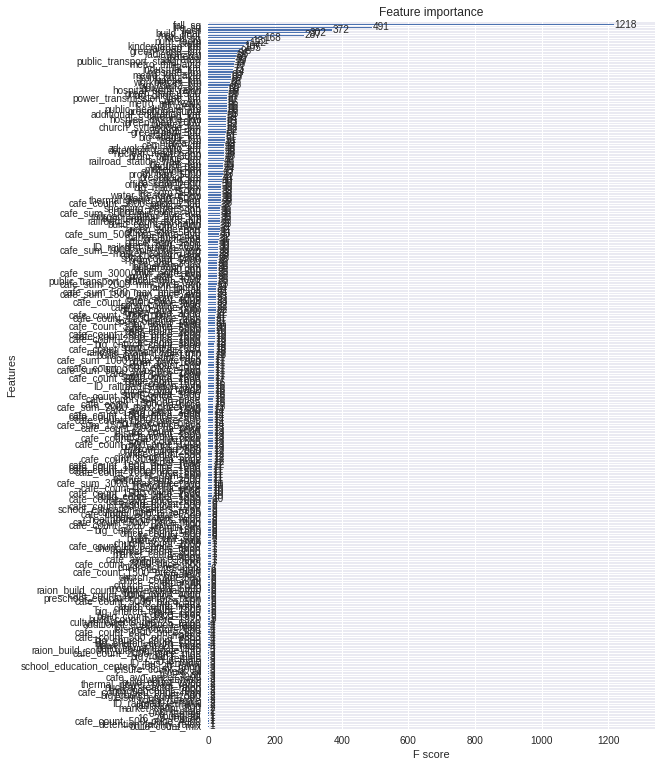

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, height=0.5, ax=ax)
xgb.plot_importance(model,n)

In [8]:


y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.head()



,id,price_doc
0,30474,5448555.5
1,30475,8517570.0
2,30476,5389902.5
3,30477,5937156.0
4,30478,5151572.0


In [117]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
from sklearn.cross_validation import cross_val_predict as cvp
xgb_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=500, silent=True, objective='reg:linear', nthread=-1, subsample=1, colsample_bytree=0.7, colsample_bylevel=0.7)


In [125]:
y_pred = cvp(xgb_model, x_train,y_train, cv=5, n_jobs = 1,verbose=10,fit_params={'eval_metric':'rmse'})

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


In [ ]:
def oof_prediction():
    """
    Dirty global variable callback hack.
    """

    global cv_prediction_dict

    def callback(env):
        """internal function"""        
        cv_prediction_list = []

        for i in [0, 1, 2, 3, 4]:
            cv_prediction_list.append([env.cvfolds[i].bst.predict(env.cvfolds[i].dtest)])

        cv_prediction_dict['cv'] = cv_prediction_list

    return callback

In [14]:
cv_prediction_dict = {}
xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, callbacks=[oof_prediction()], nfold=5)
pos_oof_predictions = cv_prediction_dict.copy()

In [128]:
y_train

0         5850000
1         6000000
2         5700000
3        13100000
4        16331452
5         9100000
6         5500000
7         2000000
8         5300000
9         2000000
10        4650000
11        4800000
12        5100000
13        5200000
14        5000000
15        1850000
16        6300000
17        5900000
18        7900000
19        5200000
20        8200000
21        5200000
22        6250000
23        5750000
24        6000000
25        1050000
26        5000000
27        4700000
28        8254400
29        5900000
           ...   
30441    25039300
30442     4350000
30443     7567425
30444    11438948
30445    10139368
30446     6125400
30447     6373324
30448     6888144
30449     9227657
30450    12610000
30451     2394300
30452     6800000
30453     4066740
30454     6300000
30455     9014972
30456     1000000
30457     7800000
30458     6370777
30459     5778893
30460     9500000
30461     5000000
30462    10544070
30463    12000000
30464    10262010
30465     

In [20]:
pos_oof_predictions['cv'][0]

[array([ 3962392.5,  5574435. ,  4348051.5, ...,  5906032. ,  6866006. ,
         4491176. ], dtype=float32)]

In [21]:
for i in pos_oof_predictions['cv']:
    print(i)

[array([ 3962392.5,  5574435. ,  4348051.5, ...,  5906032. ,  6866006. ,
        4491176. ], dtype=float32)]
[array([  7305522.  ,  12265608.  ,   6343265.5 , ...,   6685382.5 ,
        13224118.  ,   3683451.25], dtype=float32)]
[array([ 10214938. ,   4730149.5,  17234604. , ...,   5578749.5,
         5460969. ,   6078873.5], dtype=float32)]
[array([ 4313158.5,  5719757.5,  6617862.5, ...,  8093858.5,  4032708. ,
        4627651. ], dtype=float32)]
[array([  4958002.5,  13336840. ,   4737271. , ...,   6357212.5,
         7262517. ,   6401984. ], dtype=float32)]


In [32]:
a=pos_oof_predictions['cv'][0]
for i in range(1,5):
    a=np.append(a,pos_oof_predictions['cv'][i])

In [33]:
a

array([ 3962392.5,  5574435. ,  4348051.5, ...,  6357212.5,  7262517. ,
        6401984. ], dtype=float32)

In [36]:
y_train['a']=a

/home/robert/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
y_train.shape

(30472,)

In [130]:
error=pd.DataFrame({'target':y_train,'pred':y_pred})

In [64]:
for i in range(5):
    print(pos_oof_predictions['cv'][i][0].shape)

(6094,)
(6094,)
(6094,)
(6094,)
(6094,)


In [65]:
print(6094*5)

30470


In [66]:
print(30472/2)

15236.0


In [72]:
print(30472/8)

3809.0


In [77]:
x_train.shape

(30471, 289)

In [78]:
y_train.shape

(30472,)

In [151]:
error['rmse']=abs(error.pred-error.target)

In [140]:
error.error.sum()/error.shape[0]

0.24490577645926373

In [152]:
error

,pred,target,error,rmse
0,5740000.00,5850000,0.018982,110000.00
1,5804442.00,6000000,0.033136,195558.00
2,5846794.50,5700000,0.025428,146794.50
3,11396764.00,13100000,0.139283,1703236.00
4,14521574.00,16331452,0.117457,1809878.00
5,8177487.50,9100000,0.106889,922512.50
6,5842015.50,5500000,0.060328,342015.50
7,6032477.00,2000000,1.104010,4032477.00
8,6527532.00,5300000,0.208322,1227532.00
9,5969677.50,2000000,1.093545,3969677.50


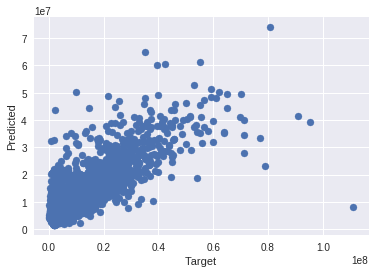

In [160]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred)
ax.set_xlabel('Target')
ax.set_ylabel('Predicted')
plt.show()

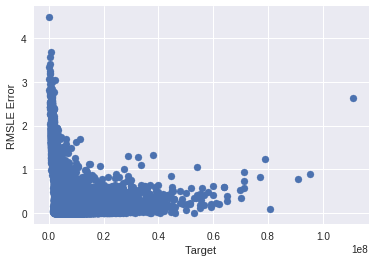

In [161]:
fig, ax = plt.subplots()
ax.scatter(y_train,error.error)
ax.set_xlabel('Target')
ax.set_ylabel('RMSLE Error')
plt.show()

In [150]:
np.exp(3)

20.085536923187668

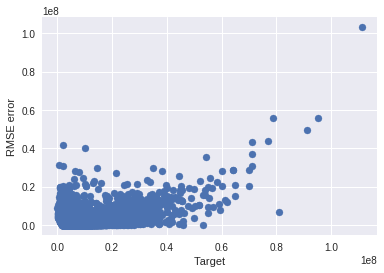

In [162]:
fig, ax = plt.subplots()
ax.scatter(y_train,error.rmse)
ax.set_xlabel('Target')
ax.set_ylabel('RMSE error')
plt.show()

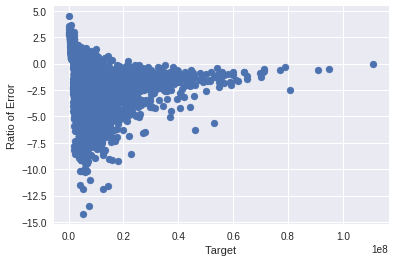

In [163]:
fig, ax = plt.subplots()
ax.scatter(y_train,np.log(error.rmse/y_train))
ax.set_xlabel('Target')
ax.set_ylabel('Ratio of Error')
plt.show()